# Weaknesses of the method PCA+Kmeans

> In this notebook, we explore the limitations of combining Principal Component Analysis (PCA) with K-Means for clustering tasks. While PCA is a powerful technique for dimensionality reduction and K-Means is widely used for clustering, their integration can sometimes lead to suboptimal results. We will demonstrate specific scenarios using simple synthetic datasets where
the PCA+K-Means approach struggles, providing insights into its weaknesses and discussing alternative strategies.

> We are well aware that the examples presented here may appear simplistic; however, they serve as a foundational stepping stone towards a comprehensive understanding of these inherent weaknesses.

> We will mainly discuss 2 weaknesses:
*   The inherently linear behavior
*   Robustness against noise



In [ ]:
# If needed 
!pip install ucimlrepo
!pip install seaborn

In [ ]:
from utils import *


import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import random
import pandas as pd

from sklearn.datasets import make_moons, make_circles, make_blobs

from ucimlrepo import fetch_ucirepo

from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import rbf_kernel

from scipy.sparse.linalg import eigsh
from scipy.special import comb
from scipy.stats import multivariate_normal
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

## Spectral Clustering implementation

In [ ]:
class SpectralClustering:
    def __init__(self, n_clusters=2, gamma=100.0):
        self.n_clusters = n_clusters
        self.gamma = gamma  # Parameter for RBF kernel
        self.labels_ = None  # Attribute to store labels

    def fit_predict(self, X):
        # Create the similarity matrix
        affinity_matrix = rbf_kernel(X, gamma=self.gamma)

        # Compute the Laplacian matrix
        D = np.diag(np.sum(affinity_matrix, axis=1))
        L = D - affinity_matrix

        # Compute the eigenvalues and eigenvectors
        eigenvalues, eigenvectors = eigsh(L, k=self.n_clusters, which='SM')
        eigenvector_matrix = eigenvectors[:, np.argsort(eigenvalues)[1:self.n_clusters]]

        # Normalize the rows of the eigenvector matrix
        norm_row = np.linalg.norm(eigenvector_matrix, axis=1)
        U = eigenvector_matrix / norm_row[:, np.newaxis]

        # Apply K-Means on the transformed data
        kmeans = KMeans(k=self.n_clusters)
        self.labels_ = kmeans.fit_predict(U)

        return self.labels_

## PCA+K-means on non-linearly separable datasets



In this experiment, we evaluate the efficacy of PCA+K-Means and Spectral Clustering on two specifically chosen datasets, make_moons and make_circles, known for their non-linearly separable structures. These structures present significant challenges for traditional clustering methods. The make_moons dataset consists of two intertwined half-moons, whereas make_circles is characterized by its concentric circles.

Initially, we implement PCA followed by K-Means on both datasets. PCA, as a linear dimensionality reduction technique, aims to maximize variance when projecting data onto lower dimensions, potentially distorting the inherent non-linear relationships in these datasets. Subsequently, K-Means, which operates based on Euclidean distance, faces difficulties in accurately delineating the complex shapes due to the linear alteration introduced by PCA.

In contrast, Spectral Clustering demonstrates a more apt approach for these specific datasets. Unlike PCA, Spectral Clustering leverages the eigenvalues of the Laplacian matrix, which is derived from the data's similarity matrix that was created using a RBF kernel, to transform the data space. This method effectively captures the intrinsic geometry and connectivity of the data, as opposed to merely focusing on variance maximization.

This transformation renders the non-linearly separable clusters, such as moons and circles, more distinguishable, often even linearly separable. Consequently, when K-Means is employed in this transformed space, it achieves greater success in accurately identifying the intended clusters.

This experiment thus highlights Spectral Clustering's superiority over PCA in handling datasets with non-linear structures, owing to its transformation approach that preserves the data's inherent geometrical properties.

In [ ]:
def perform_pca_kmeans(X, n_clusters=2):
    """
    Applies PCA for dimensionality reduction followed by KMeans clustering.

    Parameters:
    X (array-like): The input data.
    n_clusters (int): The number of clusters to form.

    Returns:
    array: Cluster labels.
    """
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    kmeans = KMeans(k=n_clusters)
    return kmeans.fit_predict(X_pca)

def plot_results(X, y_pred, title, subplot_position):
    """
    Plots the clustering results.

    Parameters:
    X (array-like): The input data.
    y_pred (array): Predicted cluster labels.
    title (str): Title of the plot.
    subplot_position (int): Position of the subplot.
    """
    plt.subplot(1, 2, subplot_position)
    plt.scatter(X[:, 0], X[:, 1], c=y_pred, cmap='viridis', marker='o')
    plt.title(title)

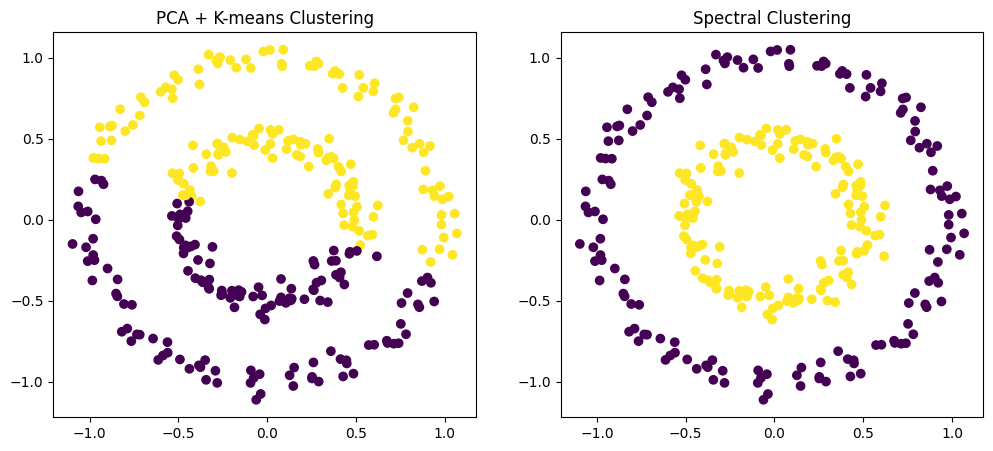

In [ ]:
# Generate Two Circles dataset
X_circles, y_circles = make_circles(n_samples=300, factor=.5, noise=.05, random_state=42)

# Apply PCA + KMeans and Spectral Clustering on Circles
y_kmeans_circle = perform_pca_kmeans(X_circles)
spectral_circle = SpectralClustering(n_clusters=2)
y_spectral_circle = spectral_circle.fit_predict(X_circles)

# Visualize the results for Circles
plt.figure(figsize=(12, 5))
plot_results(X_circles, y_kmeans_circle, 'PCA + K-means Clustering', 1)
plot_results(X_circles, y_spectral_circle, 'Spectral Clustering', 2)
plt.show()

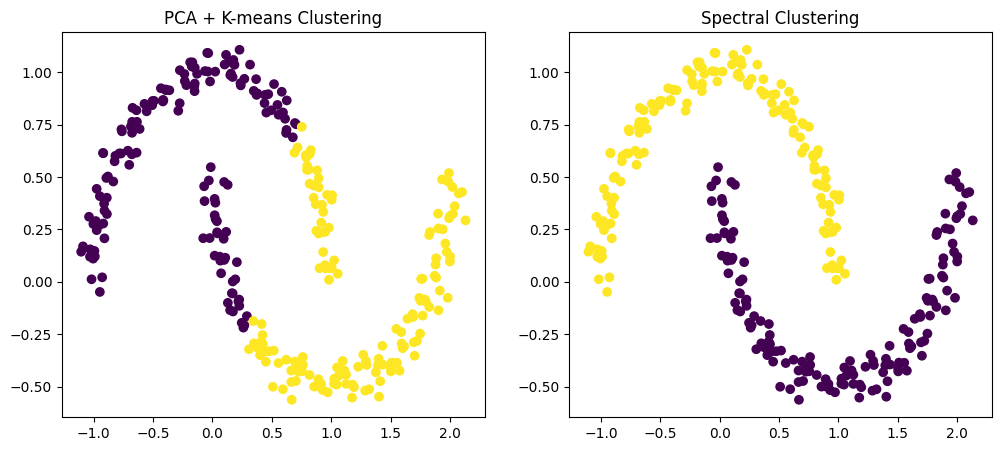

In [ ]:
# Generate Two Moons dataset
X_moon, y_moon = make_moons(n_samples=300, noise=.05, random_state=42)

# Apply PCA + KMeans and Spectral Clustering on Moons
y_kmeans_moon = perform_pca_kmeans(X_moon)
spectral_moon = SpectralClustering(n_clusters=2)
y_spectral_moon = spectral_moon.fit_predict(X_moon)

# Visualize the results for Moons
plt.figure(figsize=(12, 5))
plot_results(X_moon, y_kmeans_moon, 'PCA + K-means Clustering', 1)
plot_results(X_moon, y_spectral_moon, 'Spectral Clustering', 2)
plt.show()

**Conclusion**

Although these analyses were conducted on toy datasets, they underscore the necessity of a profound understanding of the dataset's characteristics when applying various clustering methodologies.

## Assessing the Noise Sensitivity of PCA+K-Means Clustering




### GMM implementation

In [ ]:
class GaussianMixture:
    def __init__(self, n_components=2, tol=1e-4, max_iter=100):
        # Initialize the GMM with the specified number of components, convergence tolerance, and max iterations
        self.n_components = n_components
        self.tol = tol
        self.max_iter = max_iter

    def _initialize(self, X):
        # Initialize the GMM parameters: means, covariances, and weights
        np.random.seed(0)  # Set random seed for reproducibility
        random_idx = np.random.permutation(X.shape[0])
        self.means = X[random_idx[:self.n_components]]  # Initialize means randomly
        self.covariances = [np.cov(X.T) for _ in range(self.n_components)]  # Initialize covariances
        self.weights = np.full(self.n_components, 1 / self.n_components)  # Initialize weights

    def _e_step(self, X):
        # E-step: calculate responsibilities (posterior probabilities of components given data)
        self.responsibilities = np.zeros((X.shape[0], self.n_components))
        for k in range(self.n_components):
            rv = multivariate_normal(self.means[k], self.covariances[k])
            self.responsibilities[:, k] = self.weights[k] * rv.pdf(X)
        self.responsibilities /= self.responsibilities.sum(axis=1, keepdims=True)

    def _m_step(self, X):
        # M-step: update the parameters (weights, means, covariances) using current responsibilities
        Nk = self.responsibilities.sum(axis=0)
        self.weights = Nk / X.shape[0]
        self.means = np.dot(self.responsibilities.T, X) / Nk[:, np.newaxis]
        for k in range(self.n_components):
            diff = X - self.means[k]
            self.covariances[k] = np.dot(self.responsibilities[:, k] * diff.T, diff) / Nk[k]

    def fit(self, X):
        # Fit the GMM to the data
        self._initialize(X)
        for iteration in range(self.max_iter):
            prev_means = self.means.copy()
            self._e_step(X)
            self._m_step(X)
            # Check for convergence
            if np.all(np.linalg.norm(prev_means - self.means, axis=1) < self.tol):
                break

    def predict(self, X):
        # Predict the component index for each sample in X
        self._e_step(X)
        return self.responsibilities.argmax(axis=1)

    def fit_predict(self, X):
        # Fit the model to the data and then predict the component index for each sample
        self.fit(X)
        return self.predict(X)

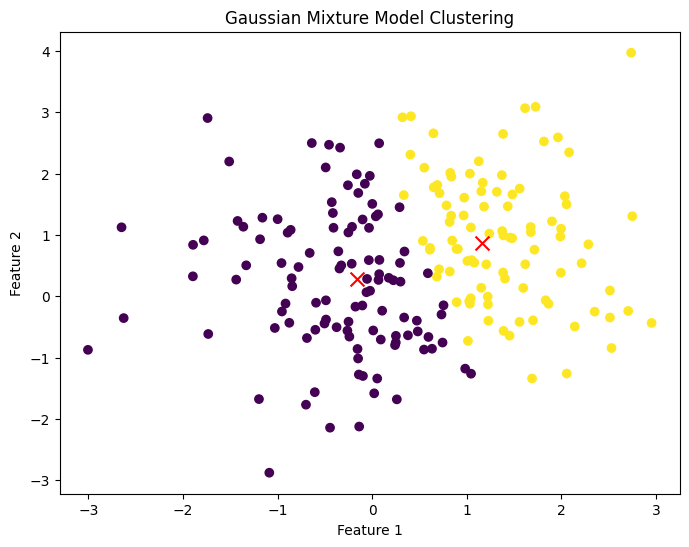

In [ ]:
'''
Basic use of case to prove this implementation works
'''

# Step 1: Create a synthetic dataset
X1 = np.random.randn(100, 2)  # First cluster
X2 = np.random.randn(100, 2) + 1  # Second cluster (offset by 5)
X = np.concatenate([X1, X2])  # Combine into one dataset

# Step 2: Instantiate and fit the GMM
gmm = GaussianMixture(n_components=2)
gmm.fit(X)

# Step 3: Predict the component for each data point
labels = gmm.predict(X)

# Step 4: Visualization
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', marker='o')  # Data points colored by assigned component
plt.scatter(gmm.means[:, 0], gmm.means[:, 1], c='red', marker='x', s=100)  # Component centroids
plt.title('Gaussian Mixture Model Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

**Methodology**

In this subsequent experiment, our objective is to conduct a comparative analysis of the PCA+K-means and Gaussian Mixture Models (GMM) in terms of their performance under progressively increasing levels of noise.

To systematically vary the noise levels, we manipulate the standard deviation parameter. This is achieved by generating synthetic datasets utilizing the make_blobs function from scikit-learn. The datasets thus created will enable us to meticulously chart the relationship between the noise level and two key metrics: clustering accuracy and the Davies-Bouldin (DB) index. This approach is intended to rigorously assess the sensitivity of both PCA+K-means and GMM to noise interference.

For the sake of robustness, each noise level will be subjected to 10 iterations of the clustering process, aiming to minimize the influence of initialization variability on our results.

In the setup of our synthetic datasets, we have chosen specific parameters: 10 features, 7 clusters, and a range for the standard deviation of the synthetic distribution extending from 1 to 10. The PCA reduction will project the data on the 3 first principal components. These parameters are selected to provide a comprehensive overview of the methods' performances across varying noise intensities.

For practical considerations, we opt to use the **GMM implementation provided by scikit-learn**. This decision is driven by efficiency concerns, as our custom implementation of GMM exhibits a considerably slower performance. This choice ensures that our experimental results are obtained in a timely manner, without compromising on the accuracy and reliability of the findings.

## Experiments

In [ ]:
# Create synthetic datasets with increasing levels of noise
datasets = []
noise_levels = np.arange(1, 10, .5).tolist()
n_initializations = 10
n_samples = 1000
n_features = 10
n_clusters = 7
accuracy_res = []
DB_res = []

for noise in noise_levels:
    X, y_true = make_blobs(n_samples=n_samples, n_features=n_features, centers=n_clusters, cluster_std=noise, random_state=41)
    datasets.append((X, y_true))

avg_accu_kmeans = []
avg_accu_gmm = []
avg_DB_kmeans = []
avg_DB_gmm = []

for X, y_true in datasets:
    ls_accu_kmeans = []
    ls_accu_gmm = []
    ls_DB_kmeans = []
    ls_DB_gmm = []

    for _ in range(n_initializations):
        # PCA + K-means
        pca = PCA(n_components=2)
        reduced_X = pca.fit_transform(X)
        kmeans = KMeans(k=n_clusters)
        kmeans_labels = kmeans.fit_predict(reduced_X)

        # GMM
        gmm = GaussianMixture(n_components=n_clusters)
        gmm_labels = gmm.fit_predict(X)

        # Calculate ARI scores
        accu_kmeans = clustering_accuracy(y_true, kmeans_labels)
        accu_gmm = clustering_accuracy(y_true, gmm_labels)
        ls_accu_kmeans.append(accu_kmeans)
        ls_accu_gmm.append(accu_gmm)

        DB_kmeans = davies_bouldin_score(X, kmeans_labels)
        DB_gmm = davies_bouldin_score(X, gmm_labels)
        ls_DB_kmeans.append(DB_kmeans)
        ls_DB_gmm.append(DB_gmm)

    avg_accu_kmeans.append(np.mean(ls_accu_kmeans))
    avg_accu_gmm.append(np.mean(ls_accu_gmm))
    avg_DB_kmeans.append(np.mean(ls_DB_kmeans))
    avg_DB_gmm.append(np.mean(ls_DB_gmm))

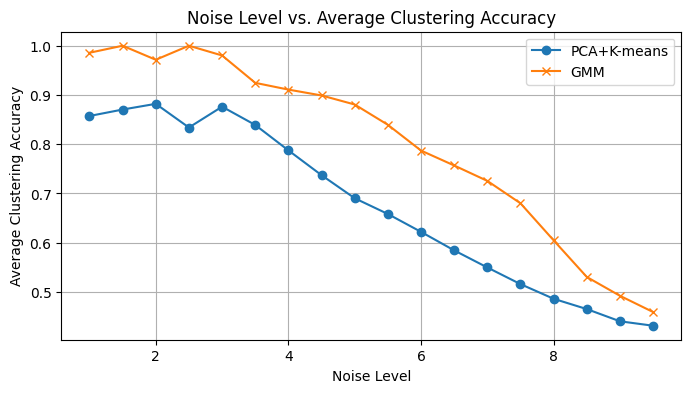

In [ ]:
# Plot noise level versus average ARI scores
plt.figure(figsize=(8, 4))
plt.plot(noise_levels, avg_accu_kmeans, label='PCA+K-means', marker='o')
plt.plot(noise_levels, avg_accu_gmm, label='GMM', marker='x')
plt.xlabel('Noise Level')
plt.ylabel('Average Clustering Accuracy')
plt.title('Noise Level vs. Average Clustering Accuracy')
plt.legend()
plt.grid(True)
plt.show()

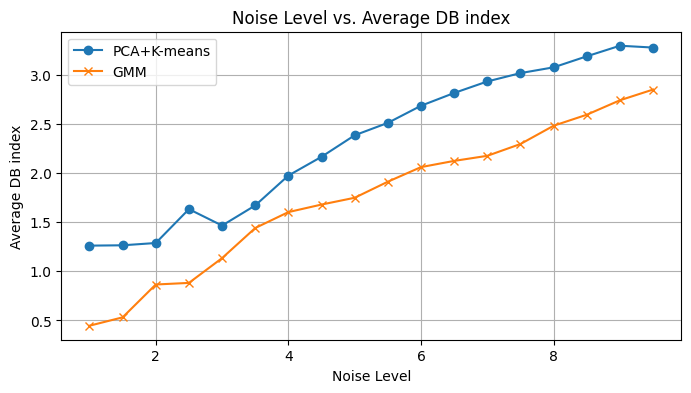

In [ ]:
# Plot noise level versus average ARI scores
plt.figure(figsize=(8, 4))
plt.plot(noise_levels, avg_DB_kmeans, label='PCA+K-means', marker='o')
plt.plot(noise_levels, avg_DB_gmm, label='GMM', marker='x')
plt.xlabel('Noise Level')
plt.ylabel('Average DB index')
plt.title('Noise Level vs. Average DB index')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
t_statistic, p_value = stats.ttest_rel(avg_accu_gmm, avg_accu_kmeans)

# Print the results
print("Paired t-test results:")
print("T-statistic:", t_statistic)
print("P-value:", p_value)

alpha = 0.05

if p_value < alpha:
    print("The difference in Clustering Accuracy scores between GMM and K-means is statistically significant.")
else:
    print("There is no statistically significant difference in Clustering Accuracy between GMM and K-means.")

t_statistic, p_value = stats.ttest_rel(avg_DB_gmm, avg_DB_kmeans)

print("-------------")

# Print the results
print("Paired t-test results:")
print("T-statistic:", t_statistic)
print("P-value:", p_value)

alpha = 0.05

if p_value < alpha:
    print("The difference in DB index between GMM and K-means is statistically significant.")
else:
    print("There is no statistically significant difference in DB index between GMM and K-means.")

Paired t-test results:
T-statistic: 11.179095579609507
P-value: 2.9515789166650075e-09
The difference in Clustering Accuracy scores between GMM and K-means is statistically significant.
-------------
Paired t-test results:
T-statistic: -14.776113214377538
P-value: 3.9296511282782043e-11
The difference in DB index between GMM and K-means is statistically significant.


**Limitations and Observations in PCA Component Selection**

It is important to acknowledge that our experiment exhibits **different bias**, one is related to the selection of the number of components retained post-PCA application. The previous results were generated with a number of components = 2.

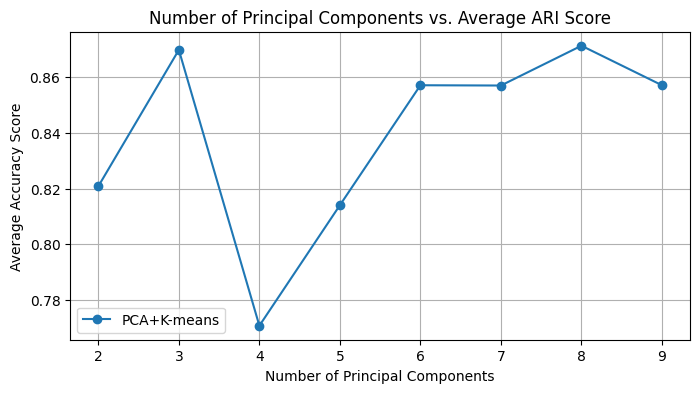

In [ ]:
# Create synthetic datasets with increasing levels of noise
n_components_pca = np.arange(2, 10, 1).tolist()

n_clusters = 7
n_initializations = 10
accu_scores = []

X, y_true = make_blobs(n_samples=1000, n_features=10, centers=7, cluster_std=2, random_state=42)

avg_accu_kmeans = []

for n_components in n_components_pca:
    accu_kmeans_list = []

    for _ in range(n_initializations):
        pca = PCA(n_components=n_components)
        reduced_X = pca.fit_transform(X)
        kmeans = KMeans(k=n_clusters)
        kmeans_labels = kmeans.fit_predict(reduced_X)

        # Calculate ARI scores
        accu_kmeans = clustering_accuracy(y_true, kmeans_labels)

        accu_kmeans_list.append(accu_kmeans)

    avg_accu_kmeans.append(np.mean(accu_kmeans_list))

# Plot number of principal components versus average ARI scores
plt.figure(figsize=(8, 4))
plt.plot(n_components_pca, avg_accu_kmeans, label='PCA+K-means', marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Average Accuracy Score')
plt.title('Number of Principal Components vs. Average ARI Score')
plt.legend()
plt.grid(True)
plt.show()

This bias is too important to have confidence in the results we have found.
Moreover, we only test one configuration of features/n_clusters

We will conduct a last experiment as robust as possible to get a final figure.

1. We will assign a random number between 2 and the number of features for the number of components of PCA to remove the bias.
2. We will increase the number of noise levels considered.
3. We will evaluate different cluster/number of features considerations.



In [ ]:
# Setup for varying data complexities
cluster_configs = [(7, 10), (10, 15), (15, 20), (20, 20), (25, 20)]  # Different (n_clusters, n_features) configurations
noise_levels = np.arange(1, 10, .1)
n_initializations = 10
n_samples = 1000

# Initialize results storage
results = []

# Experiment with varying cluster configurations
for n_clusters, n_features in cluster_configs:
    for noise in noise_levels:
        X, y_true = make_blobs(n_samples=n_samples, n_features=n_features, centers=n_clusters, cluster_std=noise, random_state=41)

        ls_accu_kmeans = []
        ls_accu_gmm = []
        ls_DB_kmeans = []
        ls_DB_gmm = []

        for _ in range(n_initializations):
            # PCA + K-means
            pca = PCA(n_components=random.randint(2, n_features))
            reduced_X = pca.fit_transform(X)
            kmeans = KMeans(k=n_clusters)
            kmeans_labels = kmeans.fit_predict(reduced_X)

            # GMM
            gmm = GaussianMixture(n_components=n_clusters, random_state=41)
            gmm_labels = gmm.fit_predict(X)

            # Calculate metrics
            accu_kmeans = clustering_accuracy(y_true, kmeans_labels)
            accu_gmm = clustering_accuracy(y_true, gmm_labels)
            ls_accu_kmeans.append(accu_kmeans)
            ls_accu_gmm.append(accu_gmm)


        # Store average results for each configuration and noise level
        results.append({
            'n_clusters': n_clusters,
            'n_features': n_features,
            'noise': noise,
            'avg_accu_kmeans': np.mean(ls_accu_kmeans),
            'avg_accu_gmm': np.mean(ls_accu_gmm)
        })

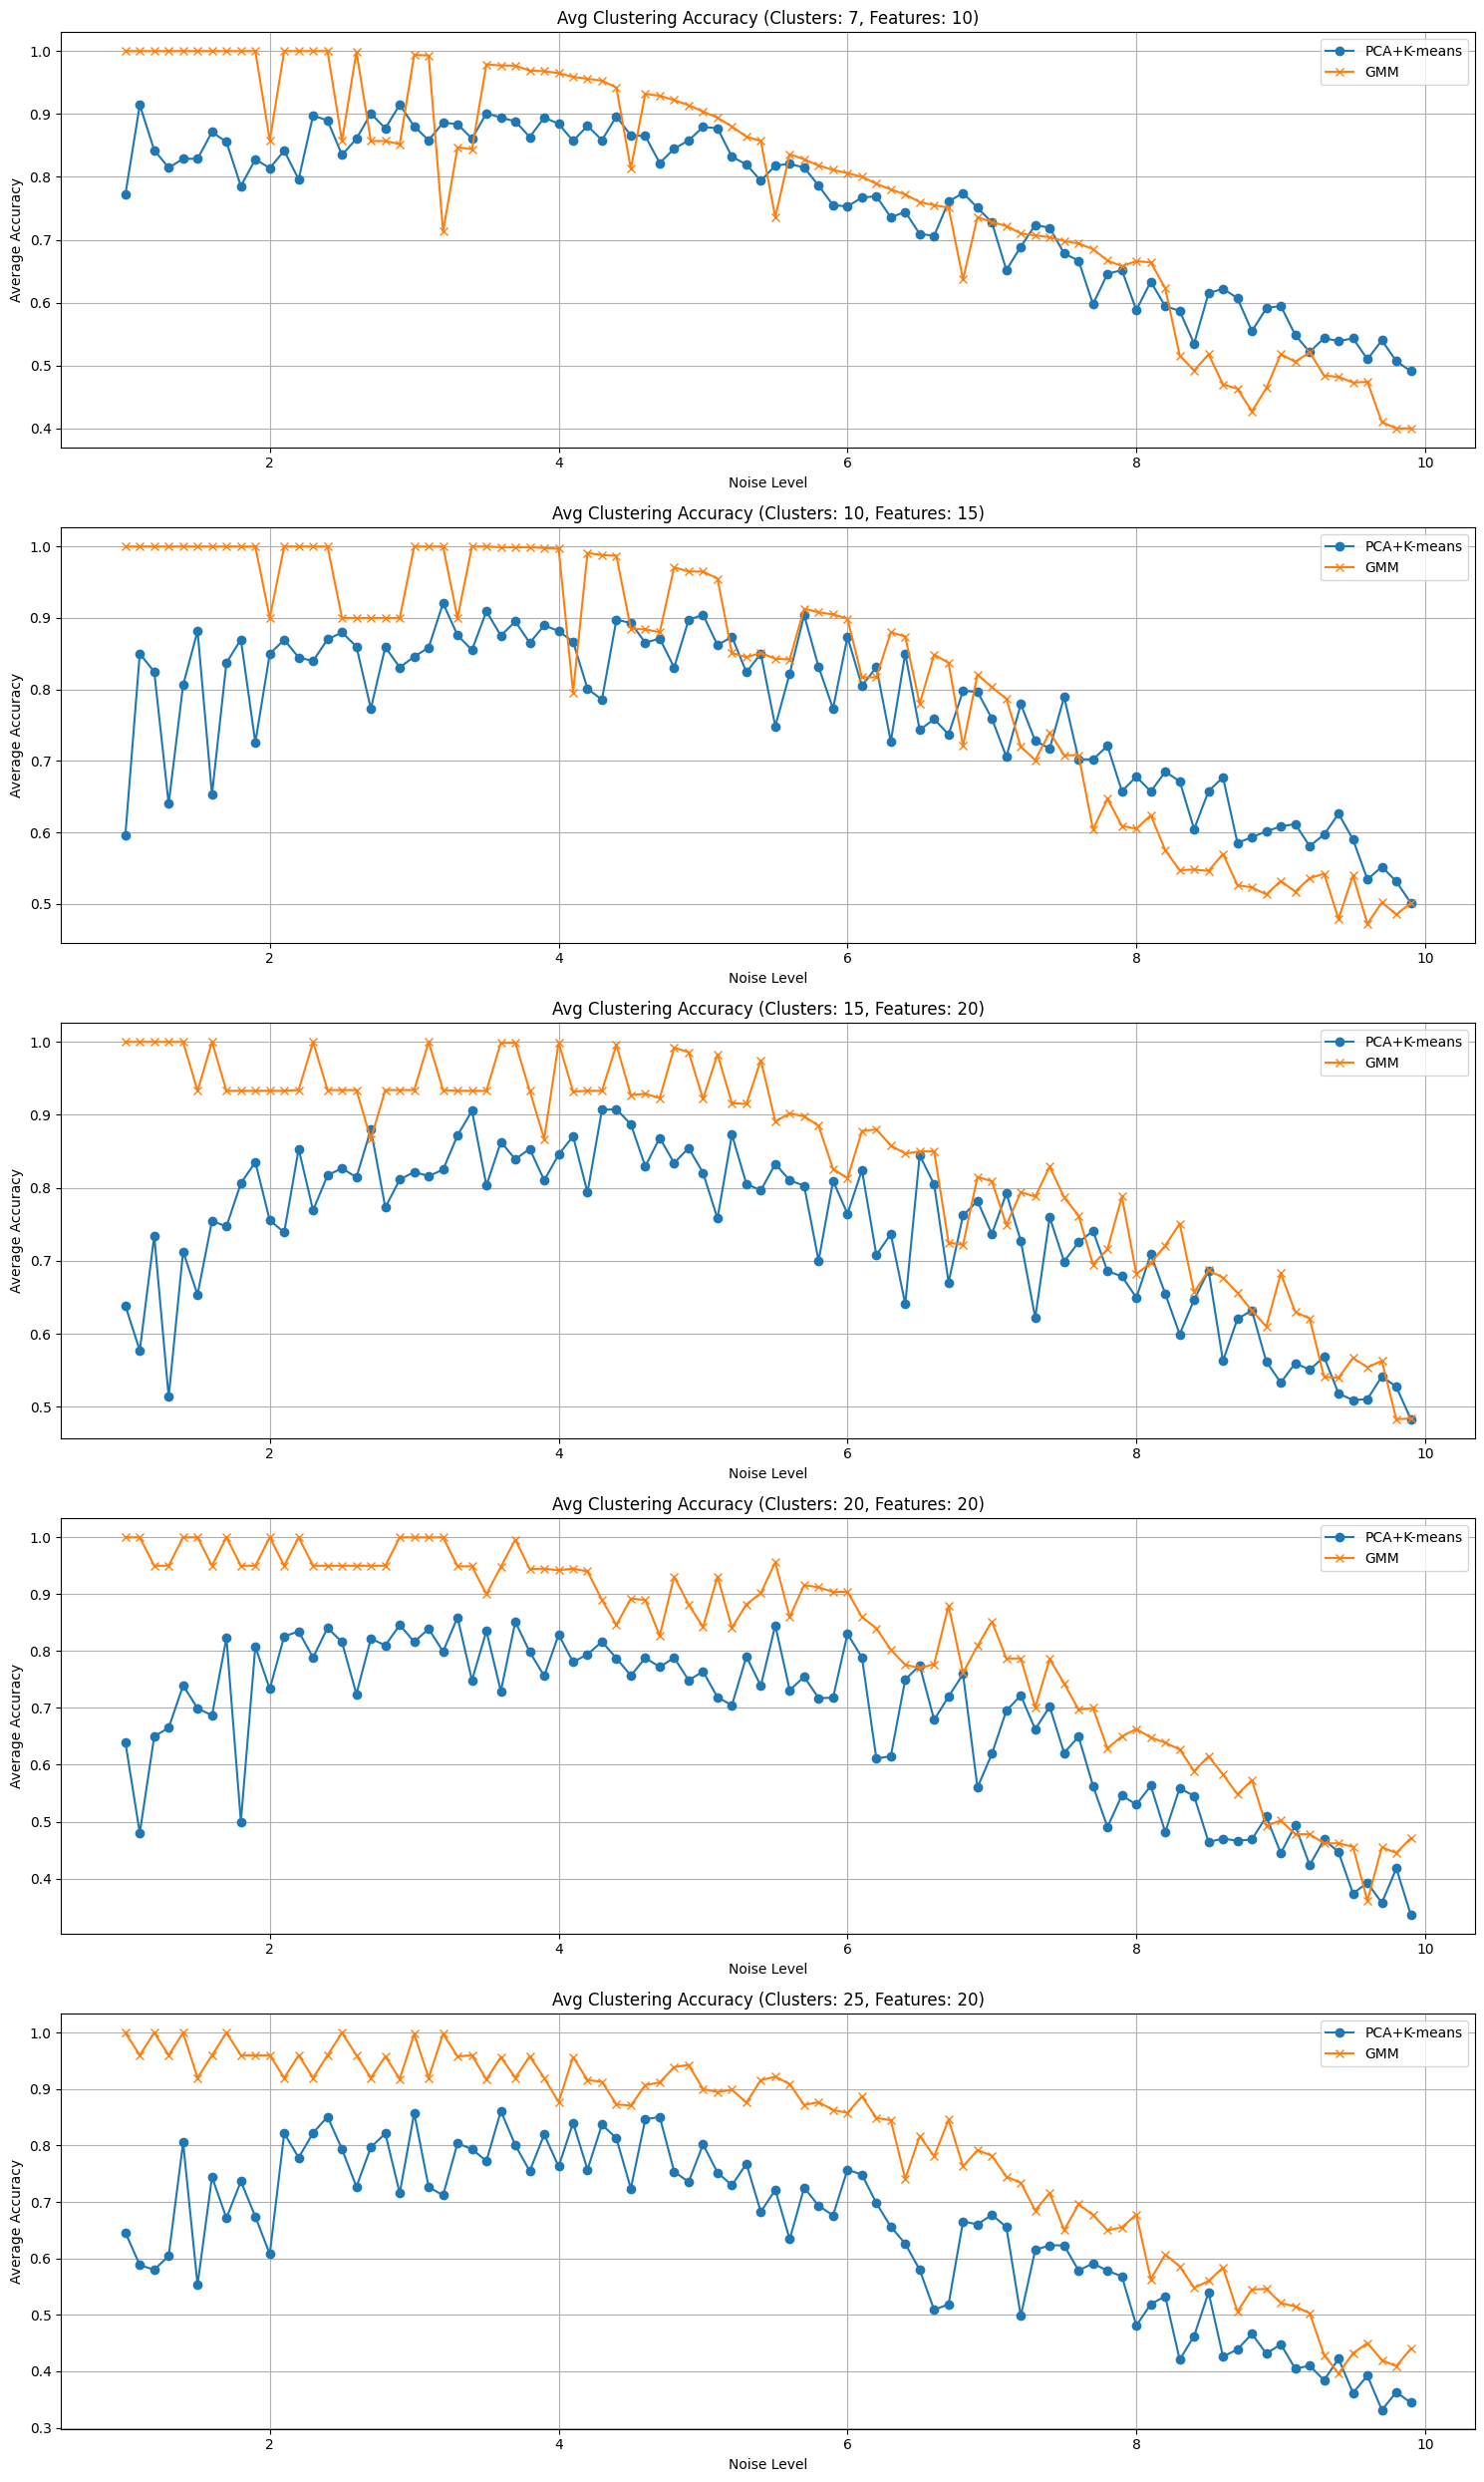

In [ ]:
# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Enhanced Visualization
fig, axs = plt.subplots(len(cluster_configs), figsize=(15, 5 * len(cluster_configs)))
for i, (n_clusters, n_features) in enumerate(cluster_configs):
    subset = results_df[(results_df['n_clusters'] == n_clusters) & (results_df['n_features'] == n_features)]

    # Plotting ARI scores
    axs[i].plot(subset['noise'], subset['avg_accu_kmeans'], label='PCA+K-means', marker='o')
    axs[i].plot(subset['noise'], subset['avg_accu_gmm'], label='GMM', marker='x')
    axs[i].set_title(f'Avg Clustering Accuracy (Clusters: {n_clusters}, Features: {n_features})')
    axs[i].set_xlabel('Noise Level')
    axs[i].set_ylabel('Average Accuracy')
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.show()

**Analysis**

Our experimental investigation has empirically shown that Gaussian Mixture Models (GMM) exhibit a greater robustness to noise compared to the PCA+K-means approach, as evidenced by both the clustering accuracy metric under conditions of escalating noise levels. This behavior is amplified when we increase the number of clusters and features that is to say when we complexify the clustering problem adding more dimensions. This finding aligns with theoretical expectations about the inherent characteristics of these models.

Theoretically, the superior performance of GMM in noisy scenarios can be attributed to its probabilistic nature. GMM, by design, incorporates the probability of each data point belonging to a given cluster, thereby accommodating the uncertainty and variability introduced by noise. This probabilistic approach allows GMM to adapt more flexibly to the nuances of the data distribution, even when the data is obscured or distorted by noise.

In contrast, PCA+K-means, which relies on variance maximization and Euclidean distances, is inherently more sensitive to noise. PCA aims to reduce dimensionality by identifying directions of maximum variance, which can be disproportionately affected by noise. Subsequently, K-means clustering on this transformed data can lead to misinterpretation of the clusters, as noise can significantly alter the data's variance structure.

Furthermore, the DB index, a metric for evaluating the compactness and separation of clusters, tends to favor GMM in noisy conditions. The ability of GMM to model the extent and shape of each cluster probabilistically provides a more nuanced understanding of cluster boundaries, even when noise is present. This contrasts with PCA+K-means, where noise can lead to overlapping or poorly defined clusters, adversely affecting the DB index.

**Conclusion**

In conclusion, our experimental results, reinforced by theoretical considerations, establish GMM as a more robust choice for clustering in the presence of noise. This robustness is primarily due to GMM's probabilistic framework, which effectively handles the uncertainties and distortions introduced by noise, a capability that PCA+K-means lacks due to its reliance on variance maximization and Euclidean distances.

**Further experiments directions**

Other weaknesses could be further invest in other studies such as the problem of **finding the number of clusters when it is unknown**.

Additional experiments for exploration in future studies might include addressing the challenge of determining the optimal number of clusters in scenarios where this quantity is unknown.

The Elbow method, commonly associated with K-means clustering, operates without a solid mathematical underpinning. It is essentially a heuristic reliant on the visual examination of the within-cluster sum of squares (WCSS) plotted against the number of clusters. The selection of the 'elbow' point on this plot as the optimal cluster number is inherently subjective. This method's effectiveness is often compromised by its ambiguity and potential for misinterpretation, particularly in datasets where the elbow is not distinctly identifiable.

Contrastingly, Gaussian Mixture Models (GMM) incorporate the Bayesian Information Criterion (BIC) to ascertain the optimal cluster count. BIC offers a mathematically rigorous framework by effectively balancing model complexity against the goodness of fit. It imposes penalties on models with excessive parameters, such as additional clusters in GMM, while rewarding models that better fit the data. This characteristic renders BIC a robust and mathematically justified tool for determining the number of clusters in GMM. It quantifiably assesses the compromise between model intricacy and fitting precision. BIC's methodological basis is anchored in Bayesian statistical principles, providing a well-founded and stringent approach to the selection of cluster numbers.